# Assignment 2  
 
### Dataset: Amazon Reviews 2023 — Electronics.jsonl

## Part 1 — Predictive task, evaluation, baselines, and validity
### 1.1 Predictive task

Primary task: Predict the star rating (1–5) that a reviewer gives a product in the Electronics category.

- Type: Regression (predict numeric rating) with optional discrete rounding to 1..5 for classification-like evaluation.

Why this task?

- It is directly useful (e.g., product recommender systems, review summarization, product quality modeling).

- It lets us combine textual signals (review text), metadata (verified_purchase, review length), and collaborative signals (user/item historical averages or latent factors).

### 1.2 How will the model be evaluated

Primary evaluation metrics on held-out test data:

- MSE (Mean Squared Error) and RMSE — favors penalizing larger errors.

- MAE (Mean Absolute Error) — interpretable in rating units.

- If we round to discrete ratings, also report classification accuracy and confusion matrix.

Validation procedure:

- Hold-out split: Reserve 5–10% of the earliest/largest dataset chunk as a test set, keep a validation set (e.g., last 10k interactions) to tune hyperparameters. Use the same splitting strategy as the course (first 190k train, last 10k validation) if required.

- Perform k-fold cross-validation (k=3) for smaller-scale experiments to check stability.

Important secondary checks:

- Evaluate per-item and per-user RMSE to detect bias where rare users/items produce high errors.

- Report distribution of residuals (histograms) and plot predicted vs actual ratings.

### 1.3 Baselines for comparison

Start with simple baselines:

1. Global mean: Predict the global average rating.

2. User mean / item mean: If user or item is seen in training. 

3. Bias-only (alpha + bu + bi): Model with global mean + regularized user and item biases solved via SGD or closed-form updates.

4. Similarity-based (item-item using Jaccard or cosine): Weighted average of ratings on similar items.

5. Text-only model: TF-IDF of review text + linear regressor (or logistic regression for discrete labels).

6. Latent factor model: Matrix factorization (bias + latent factors) trained with SGD.

### 1.4 Assessing the validity of predictions

- Calibration: Check whether predicted continuous outputs match empirical distribution (apply isotonic regression if necessary).

- Residual analysis: Plot residuals vs predicted and vs features (item popularity, review length, verified flag).

- Stratified performance: Report RMSE by rating bins, by item popularity deciles, and by user activity to ensure fairness/stability.

- Held-out / private set: Avoid overfitting by using internal cross-validation.

- Error analysis: Manually inspect examples with large absolute error to find missing signals.

## Part 2 — Exploratory analysis, data collection, preprocessing, code, and discussion

## Discussion and interpretation
Where the data came from

The dataset comes from the Amazon product review dump (Electronics subset) and is widely used in academic research for studying recommender systems and review text analysis. Reviews are collected from Amazon users; each JSONL row contains review text, rating, timestamps, and metadata (ASIN, user ID, helpful vote counts, verified purchase flag).

### Preprocessing summary

- Kept only reviews with non-null rating and text.

- Converted timestamp to datetime where possible.

- Engineered:

  - review_len_words, review_len_chars (text length signals),

  - help_ratio (normalized helpfulness),

  - verified_purchase (boolean flag).

- For text features: lowercasing, TF-IDF (unigrams + bigrams), min_df to exclude ultra-rare tokens.

### Key EDA findings

- Strong positive skew in ratings: 4–5 stars dominate. This requires careful baseline selection and use of RMSE/MAE rather than accuracy.

- Verified purchases tend to produce slightly higher and less variable ratings — include as a feature.

- Low ratings often have longer reviews (useful for text-based models).

- Popular items dominate volume; collaborative models must handle item popularity and cold-starts.

In [49]:
# Cell: imports and path
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
sns.set(style="whitegrid")
DATA_PATH = Path("/Users/andresriera/Documents/Clases UCSD/Senior/Fall 2025/CSE 158R/Assignment-2-CSE-158R-/Electronics.jsonl")


In [79]:
# Cell: load sample (adjust n_lines if needed)
def load_jsonl_sample(path, n_lines=None):
    rows = []
    with open(path, "rt", encoding="utf8") as f:
        for i, line in enumerate(f):
            if n_lines is not None and i >= n_lines:
                break
            try:
                rows.append(json.loads(line))
            except Exception:
                try:
                    rows.append(eval(line))
                except Exception:
                    continue
    return pd.DataFrame(rows)

df = load_jsonl_sample(DATA_PATH, n_lines=250000)
print("Loaded rows:", len(df))
df.head()


Loaded rows: 250000


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,3.0,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline ...,[{'small_image_url': 'https://m.media-amazon.c...,B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1658185117948,0,True
1,1.0,Didn’t work at all lenses loose/broken.,These didn’t work. Idk if they were damaged in...,[],B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1592678549731,0,True
2,5.0,Excellent!,I love these. They even come with a carry case...,[],B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093017534,0,True
3,5.0,Great laptop backpack!,I was searching for a sturdy backpack for scho...,[],B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,1290278495000,18,True
4,5.0,Best Headphones in the Fifties price range!,I've bought these headphones three times becau...,[],B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,1676601581238,0,True


In [80]:
# Cell: normalize columns
df.columns.tolist()
# Standardize column names
# relevant columns are:
# rating, title, text, images, asin, parent_asin, user_id, timestamp, helpful_vote, verified_purchase

col_map = {}
for c in df.columns:
    lc = c.lower()
    if lc in ["overall", "rating", "stars"]:
        col_map[c] = "rating"
    if lc in ["reviewtext", "review_text", "text", "review_body"]:
        col_map[c] = "text"
    if lc in ["reviewtime", "timestamp", "review_time"]:
        col_map[c] = "timestamp"
    if lc in ["helpful", "helpful_vote", "helpful_votes"]:
        col_map[c] = "helpful_vote"
    if lc in ["verified", "verified_purchase"]:
        col_map[c] = "verified_purchase"
df = df.rename(columns=col_map)
df.head()


,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,3.0,Smells like gasoline! Going back!,First & most offensive: they reek of gasoline ...,[{'small_image_url': 'https://m.media-amazon.c...,B083NRGZMM,B083NRGZMM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1658185117948,0,True
1,1.0,Didn’t work at all lenses loose/broken.,These didn’t work. Idk if they were damaged in...,[],B07N69T6TM,B07N69T6TM,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1592678549731,0,True
2,5.0,Excellent!,I love these. They even come with a carry case...,[],B01G8JO5F2,B01G8JO5F2,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,1523093017534,0,True
3,5.0,Great laptop backpack!,I was searching for a sturdy backpack for scho...,[],B001OC5JKY,B001OC5JKY,AGGZ357AO26RQZVRLGU4D4N52DZQ,1290278495000,18,True
4,5.0,Best Headphones in the Fifties price range!,I've bought these headphones three times becau...,[],B013J7WUGC,B07CJYMRWM,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,1676601581238,0,True


In [57]:
# Cell: basic cleaning
# Drop rows without rating or text (for text models we need text)
df = df.dropna(subset=["rating", "text"])
df["rating"] = df["rating"].astype(float)
df["text"] = df["text"].astype(str)

# timestamp -> datetime if numeric epoch in ms
if df["timestamp"].dtype.kind in ("i","u","f"):
    df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", errors="coerce")
else:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

# helpful ratio (if provided)
if "helpful_vote" in df.columns:
    max_help = max(df["helpful_vote"].max(), 1)
    df["help_ratio"] = df["helpful_vote"] / max_help
else:
    df["help_ratio"] = 0.0

# verified flag normalization
if "verified_purchase" in df.columns:
    df["verified_purchase"] = df["verified_purchase"].astype(bool)
else:
    df["verified_purchase"] = False

# review length features
df["review_len_chars"] = df["text"].str.len()
df["review_len_words"] = df["text"].str.split().str.len().fillna(0).astype(int)

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   rating             250000 non-null  float64       
 1   title              250000 non-null  object        
 2   text               250000 non-null  object        
 3   images             250000 non-null  object        
 4   asin               250000 non-null  object        
 5   parent_asin        250000 non-null  object        
 6   user_id            250000 non-null  object        
 7   timestamp          250000 non-null  datetime64[ns]
 8   helpful_vote       250000 non-null  int64         
 9   verified_purchase  250000 non-null  bool          
 10  help_ratio         250000 non-null  float64       
 11  review_len_chars   250000 non-null  int64         
 12  review_len_words   250000 non-null  int64         
dtypes: bool(1), datetime64[ns](1), float64(2), i

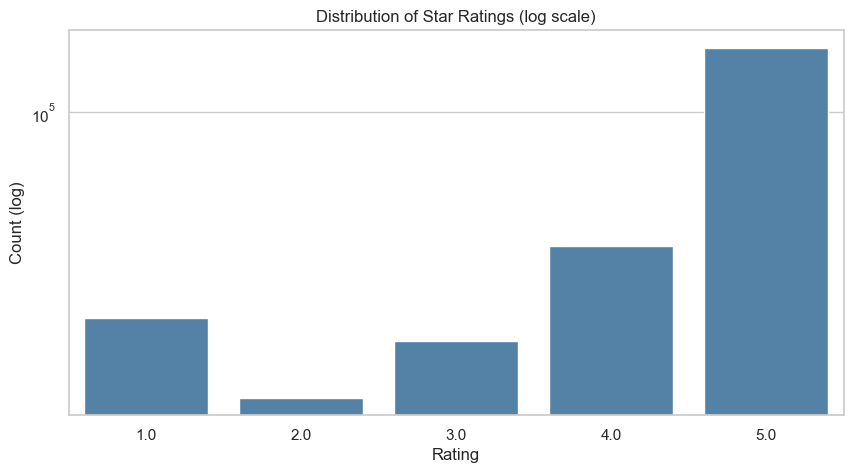

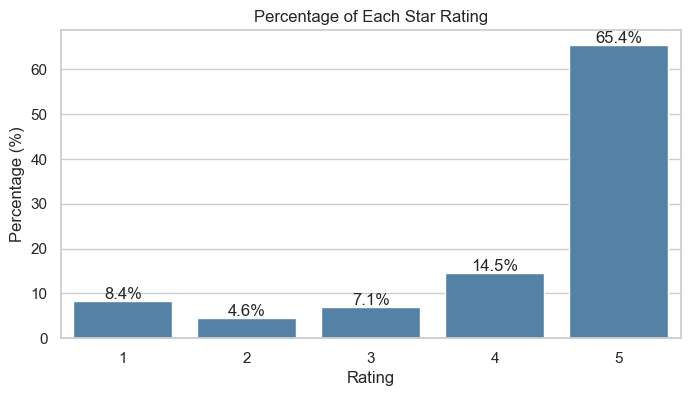

In [58]:
# Cell: Rating distribution (count + percent)
plt.figure(figsize=(10,5))
order = sorted(df["rating"].unique())
sns.countplot(x="rating", data=df, order=order, color="steelblue")
plt.yscale("log")
plt.title("Distribution of Star Ratings (log scale)")
plt.xlabel("Rating")
plt.ylabel("Count (log)")
plt.show()

# Percentage bar
plt.figure(figsize=(8,4))
rating_counts = df["rating"].value_counts(normalize=True).sort_index() * 100
sns.barplot(x=rating_counts.index.astype(int), y=rating_counts.values, color="steelblue")
plt.title("Percentage of Each Star Rating")
plt.xlabel("Rating")
plt.ylabel("Percentage (%)")
for i, v in enumerate(rating_counts.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha="center")
plt.show()


/var/folders/nf/c2yd7f4171118427n9_b_5180000gn/T/ipykernel_47871/1266924035.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="verified_purchase", y="rating", inner="quartile", palette="Blues")


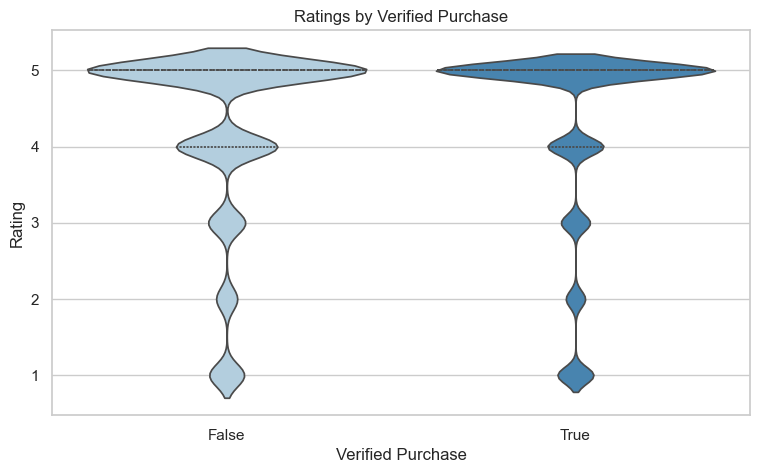

In [81]:
# Cell: Verified vs not
plt.figure(figsize=(9,5))
sns.violinplot(data=df, x="verified_purchase", y="rating", inner="quartile", palette="Blues")
plt.title("Ratings by Verified Purchase")
plt.xlabel("Verified Purchase")
plt.ylabel("Rating")
plt.show()



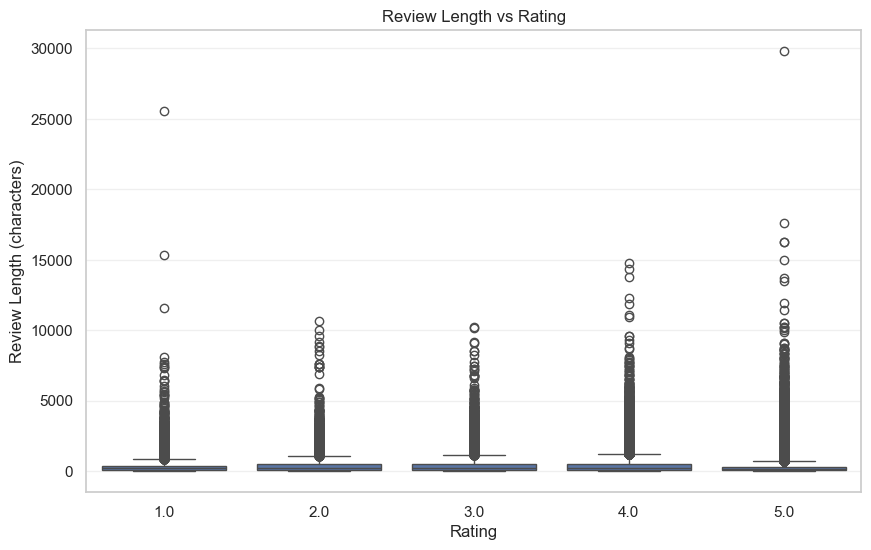

In [85]:
df["review_length"] = df["text"].str.len()

plt.figure(figsize=(10,6))
sns.boxplot(x="rating", y="review_length", data=df)
plt.title("Review Length vs Rating")
plt.ylabel("Review Length (characters)")
plt.xlabel("Rating")
plt.grid(axis="y", alpha=0.3)
plt.show()

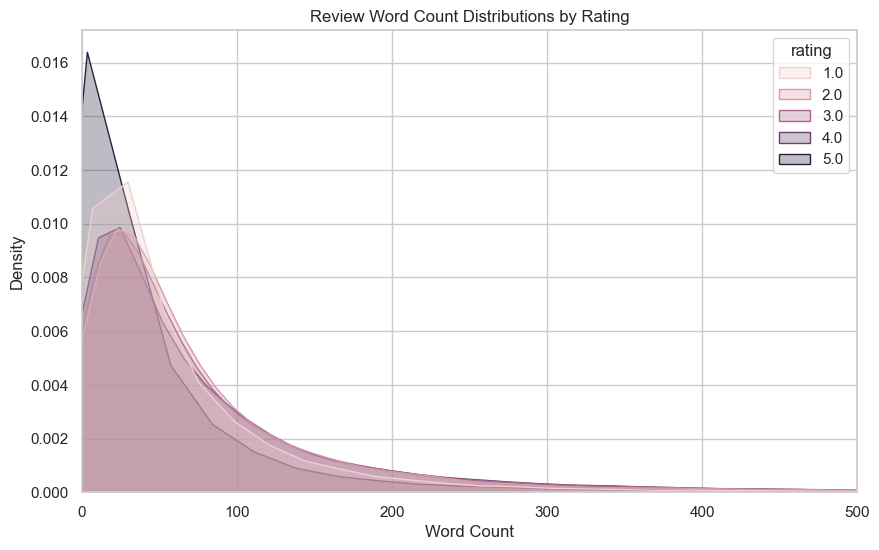

In [90]:
# Create word count column from the 'text' field
df["review_len_words"] = (
    df["text"]
    .astype(str)
    .apply(lambda x: len(x.split()))
)

plt.figure(figsize=(10,6))
sns.kdeplot(
    data=df,
    x="review_len_words",
    hue="rating",
    common_norm=False,
    fill=True,
    alpha=0.3
)
plt.xlim(0, 500)
plt.title("Review Word Count Distributions by Rating")
plt.xlabel("Word Count")
plt.show()

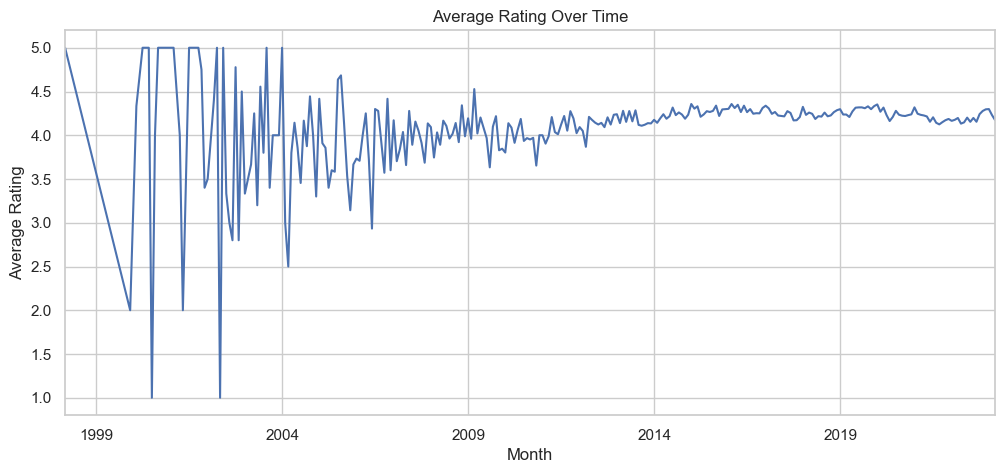

In [87]:
# Convert timestamp (in milliseconds) to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms", errors="coerce")

# Group by month
df_time = df.groupby(df["timestamp"].dt.to_period("M"))["rating"].mean()

# Plot
df_time.plot(figsize=(12,5))
plt.title("Average Rating Over Time")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.show()



/var/folders/nf/c2yd7f4171118427n9_b_5180000gn/T/ipykernel_47871/6052437.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_items.values, y=top_items.index, palette="mako")


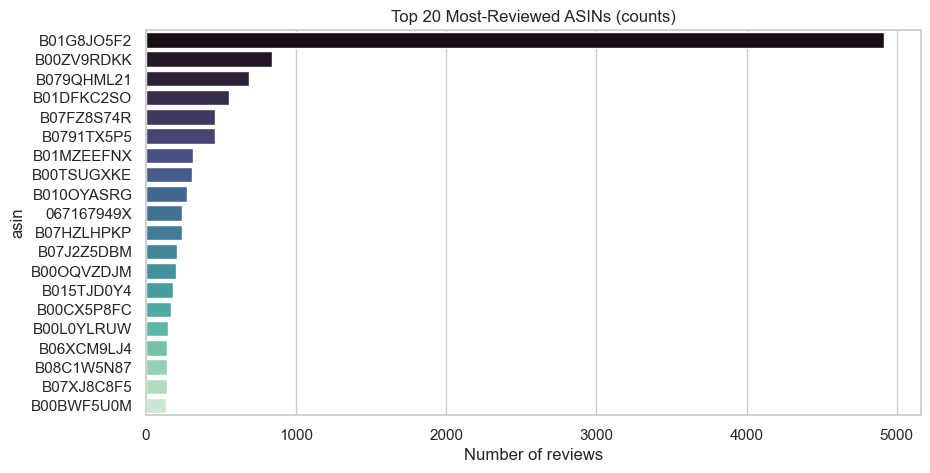

Top users (review counts):
user_id
AEIIRIHLIYKQGI7ZOCIJTRDF5NPQ    1034
AFTZWAK3ZHAPCNSOT5GCKQDECBTQ     820
AECTQQX663PTF5UQ2RA5TUL3BXVQ     764
AG73BVBKUOH22USSFJA5ZWL7AKXA     592
AGZZXSMMS4WRHHJRBUJZI4FZDHKQ     574
AG375WAXLZ7PIOQKIQ6KQB4J3JVQ     563
AHDZKPPKUT7HD47LXCBN7RQNN6KQ     492
AGBG3KK74IKWJNQVMQAGVBWJ7FAQ     417
AGDSEYGSA5K664EUHWKV3ARDXO2Q     412
AGRPLHGW2CR6WWOHT5TOWXDGIZEQ     369
Name: count, dtype: int64


In [88]:
# Cell: popularity
top_items = df["asin"].value_counts().head(20)
plt.figure(figsize=(10,5))
sns.barplot(x=top_items.values, y=top_items.index, palette="mako")
plt.title("Top 20 Most-Reviewed ASINs (counts)")
plt.xlabel("Number of reviews")
plt.show()

# users with many reviews
top_users = df["user_id"].value_counts().head(10)
print("Top users (review counts):")
print(top_users)
